<p style="text-align: center;font-size: 60px;">Stars</p>
<br\><br\>
PLAsTiCC Astronomical Classification<br/>
https://www.kaggle.com/c/PLAsTiCC-2018

1. Problem: Can we idnetify star's type based on observed information? 
2. Goal: Categorize star type based on their constant properties and light ratio changes in different passbands
3. Evaluation

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import random
import math
import sys
from sklearn.datasets import make_classification
import time
import gc
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import cesium.featurize as featurize
from scipy import signal
import warnings
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib.pyplot import figure
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

## Load MetaData and TimeSeries Data--edit your file path here

In [91]:
# Load and Show Training Metatata
# tm: train_metadata
TM = pd.read_csv('../training_set_metadata.csv')
# print(TM.shape[0])
# TM.sort_values(by=['object_id'], ascending=True).head(10)
TS=pd.read_csv('../training_set.csv')
# print(TS.shape[0])
# TS.sort_values(by=['object_id'],ascending=True).head(10)
cfeats=pd.read_csv('/Users/Nathan/OneDrive/WPI/CLASS/Machine Learning/Project/cfeats.csv',header=[0,1],index_col=0)
allshrink=pd.read_csv('./allshrink.csv',index_col=0)
alllabel=pd.read_csv('./alllabel.csv',index_col=0)
# TS=pd.read_csv('/Users/Nathan/OneDrive/WPI/CLASS/Machine Learning/Project/TimeSeries2.csv',index_col=0)

In [185]:
# len(TM.object_id.unique())
# TM.sort_values(by=['object_id'], ascending=True).head(10)
allshrink.head()

,object_id,passband0_mjd_size,passband1_mjd_size,passband2_mjd_size,passband3_mjd_size,passband4_mjd_size,passband5_mjd_size,passband0_passband_min,passband1_passband_min,passband2_passband_min,...,peakfreq_2_positive,peakfreq_3_positive,peakfreq_4_positive,peakfreq_5_positive,peakfreq_0_negative,peakfreq_1_negative,peakfreq_2_negative,peakfreq_3_negative,peakfreq_4_negative,peakfreq_5_negative
6640,121779085,15,10,22,20,31,39,0,1,2,...,0,0,0,0,0,0,0,0,0,0
7251,86188652,10,15,19,20,35,38,0,1,2,...,0,0,0,0,0,0,0,0,0,0
7689,90739539,9,13,24,18,32,40,0,1,2,...,0,0,0,0,0,0,0,0,0,0
6257,174980,72,52,40,51,51,51,0,1,2,...,0,0,0,0,0,0,0,0,0,0
4952,47747067,13,12,19,25,32,33,0,1,2,...,0,0,0,0,0,0,0,0,0,0


## Preprocess Steps
1. For target class in MetaData, divide trainging and testing by 70% and 30%
1. For non-target class, use bootstrapping sampling method to generate training sample (non-selected)
1. For the rest of them, join to testing dataset as non-target class
1. For now there's no k-fold cross validation here
1. For the target class in training dataset, choose some object_id, shows the time-series pattern to analyze possible featrues. Require to merge the training target into timesries data first.

In [186]:
# get the distribution of each class first
distribution={}
for index, row in TM.iterrows():
    target=row['target']
    if target not in distribution:
        distribution[target]={}
        distribution[target]['member']=[]
        distribution[target]['proportion']=0.0
    distribution[target]['member'].append(row['object_id'])

total_obj=len(TM.object_id.unique())
for target in distribution:
    sub_len=len(distribution[target]['member'])
    distribution[target]['proportion']=sub_len/total_obj

## For each target class, seperate data into training set(70%) and validataion set(30%)

In [187]:
def split_train_validation(df, validation_ratio,distribution,target):
    ''' split data into train set and validation set for each target class'''
    
    train = pd.DataFrame(columns=df.columns)
    validation = pd.DataFrame(columns=df.columns)
    target_member=distribution[target]['member']
    random.seed(4)
    shuffle(target_member)
    thres=len(target_member)*(1-validation_ratio)
    for i in range(len(target_member)):
        if i <= thres:
            train=train.append(df[df['object_id']==target_member[i]],ignore_index=True)
        else:
            validation=validation.append(df[df['object_id']==target_member[i]],ignore_index=True)
    # now for all other target class, extract training sample in the same distribution, with a total amount equal to 
    # target numbers which is thres
#     print(len(train.object_id.unique()))
#     print(len(validation.object_id.unique()))
    for t in distribution:
        if t!=target:
            t_member=distribution[t]['member']
            shuffle(t_member)
            # for training dataset
            sub_thres=thres*distribution[t]['proportion']
            for i in range(len(t_member)):
                if i <= sub_thres:
                    train=train.append(df[df['object_id']==t_member[i]],ignore_index=True)
                else:
                    validation=validation.append(df[df['object_id']==t_member[i]],ignore_index=True)
    
    
#     print(len(train.object_id.unique()))
#     print(len(validation.object_id.unique()))
    return train.drop(['ra','decl','gal_l','gal_b','ddf','hostgal_specz' ,'hostgal_photoz','hostgal_photoz_err','distmod','mwebv'],axis=1),\
validation.drop(['ra','decl','gal_l','gal_b','ddf','hostgal_specz','hostgal_photoz','hostgal_photoz_err','distmod','mwebv'],axis=1)


In [6]:
# change the target number as the last parameter
mytrain, myval=split_train_validation(TM,0.3,distribution,90)

In [35]:
# this part is for testing the distribution fit, you don't have to run this
# test_dist={}
# for index, row in mytrain.iterrows():
#     target=row['target']
#     if target not in test_dist:
#         test_dist[target]={}
#         test_dist[target]['member']=[]
#         test_dist[target]['proportion']=0.0
#     test_dist[target]['member'].append(row['object_id'])

# mytotal_obj=len(mytrain.object_id.unique())/2
# print(mytotal_obj)
# for target in test_dist:
#     sub_len=len(test_dist[target]['member'])
#     test_dist[target]['proportion']=sub_len/mytotal_obj
#     print(test_dist[target]['proportion']," ",distribution[target]['proportion'])
# len(mytrain[mytrain['target']==90].object_id.unique())

1620

In [7]:
# combine training dataset and validation dataset into time-series data, rename the variable as you want
mytrain=pd.merge(mytrain,TS,how='inner',on=['object_id'])
mytrain['time'] = (mytrain['mjd'] - 40587) * 86400
mytrain['time2'] = mytrain['time'].apply(lambda x: time.ctime(x))
mytrain=mytrain.drop(['time'],axis=1)
print(mytrain.head())

  object_id target         mjd  passband       flux   flux_err  detected  \
0   6987066     90  59607.2485         1  -0.316492   2.777779         0   
1   6987066     90  59608.3802         4   9.113014  20.102022         0   
2   6987066     90  59610.2300         3   0.959905   3.562937         0   
3   6987066     90  59615.1978         2  -0.888359   3.480564         0   
4   6987066     90  59615.3806         4  20.476017  21.249695         0   

                      time2  
0  Fri Jan 28 00:57:50 2022  
1  Sat Jan 29 04:07:29 2022  
2  Mon Jan 31 00:31:12 2022  
3  Fri Feb  4 23:44:49 2022  
4  Sat Feb  5 04:08:03 2022  


In [8]:
myval=pd.merge(myval,TS,how='inner',on=['object_id'])
myval['time'] = (myval['mjd'] - 40587) * 86400
myval['time2'] = myval['time'].apply(lambda x: time.ctime(x))
myval=myval.drop(['time'],axis=1)
print(myval.head())

  object_id target         mjd  passband       flux   flux_err  detected  \
0  19402817     90  59752.2909         3  -0.273184   7.013725         0   
1  19402817     90  59769.2270         4   5.669641   6.419263         0   
2  19402817     90  59770.3126         5 -21.878939  14.864022         0   
3  19402817     90  59770.4407         4  32.963493  13.783964         0   
4  19402817     90  59771.2447         4   2.458036  12.042955         0   

                      time2  
0  Wed Jun 22 02:58:53 2022  
1  Sat Jul  9 01:26:52 2022  
2  Sun Jul 10 03:30:08 2022  
3  Sun Jul 10 06:34:36 2022  
4  Mon Jul 11 01:52:22 2022  


In [9]:
# you don't have to run this, this is for checking the result
print(len(mytrain.object_id.unique()))
print(len(myval.object_id.unique()))


2770
5078


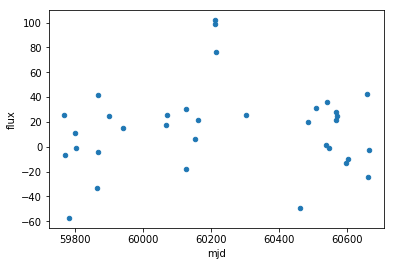

In [16]:
# now try to draw the pattern from time-series data, pick the first object from training dataset, 
# change the passband as you want
all_90=mytrain[mytrain['target']==90]
# passband 0 flux in range -30~+50, for 90% of the data, true/false
# passband 1 flux in range -10~+100, or has a maximum very high from others, most of time is positive
# passband 2 flux in range -10~+300, some very high max, most of time is positive
# passband 3 flux, if not very high, the range is just around 30-40, not always positive
# passband 4, very likely to have high max, and with many local max, relatively volatile
# passband 5, some chance to have high max, and lox min, with many local max, relatively volatile
# for i in all_90.object_id.unique():
#     if mytrain_2[(mytrain_2['object_id']==i) & (mytrain_2['passband']==1)]['flux'].max()>200:
#         print(i)
#     print(mytrain_2[(mytrain_2['object_id']==i) & (mytrain_2['passband']==2)]['flux'].min())
randobj=all_90.object_id.unique()[2]
train_randobj_1=mytrain[(mytrain['object_id']==randobj) & (mytrain['passband']==5)]
train_randobj_1.head()
train_randobj_1.drop(['object_id','passband','flux_err','detected','target'],axis=1).plot(x='mjd',y='flux',kind='scatter')

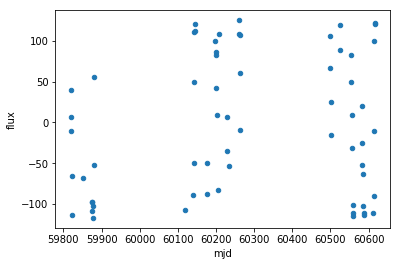

In [25]:

train_randobj_1=mytrain[(mytrain['object_id']==615) & (mytrain['passband']==0)]
train_randobj_1.head()
train_randobj_1.drop(['object_id','passband','flux_err','detected','target'],axis=1).plot(x='mjd',y='flux',kind='scatter')

In [10]:
def create_feature_max(timeseries, *args):
    passband_max=timeseries.groupby(['object_id','passband'],as_index=False)['flux'].max()
    for arg in args:
        res=passband_max[passband_max['passband']==arg]
        var="passband_"+str(arg)+"_max"
        res=res.rename(columns={"flux":var})
        yield res.drop(['passband'],axis=1)
# put the passband you want to calculate the max

    

In [11]:
def create_feature_min(timeseries,*args):
    passband_min=timeseries.groupby(['object_id','passband'],as_index=False)['flux'].min()
    for arg in args:
        res=passband_min[passband_min['passband']==arg]
        var="passband_"+str(arg)+"_min"
        res=res.rename(columns={"flux":var})
        yield res.drop(['passband'],axis=1)

In [30]:
def create_feature_quantile(timeseries,quan,*args):
    if quan>=0.5:
        inter='lower'
    else:
        inter='higher'
    passband_quantile=timeseries.groupby(['object_id','passband'],as_index=False)['flux']\
    .quantile(quan,interpolation=inter).reset_index()
    passband_quantile.columns=['object_id','passband','quantile']
    passband_quantile['quantile']=passband_quantile['quantile'].round(6)
    res_list=[]
    for arg in args:
        res=passband_quantile[passband_quantile['passband']==arg]
        var="passband_"+str(arg)+"_"+str(quan*100)+"quantile"
        res=res.rename(columns={'quantile':var})
        yield res.drop(['passband'],axis=1)
#         return res.drop(['passband'],axis=1)

In [46]:
def create_peak_freq(timeseries, quantile, peak_direction):
    col=quantile.columns[1]
    passband=int(col.split('_')[1])
    objs=timeseries.object_id.unique()
    peak_freq=pd.DataFrame(columns=['object_id','peak_freq'])
    for obj in objs:
        tm=timeseries[(timeseries['object_id']==obj) &(timeseries['passband']==passband)]
        quan=quantile.loc[quantile['object_id']==obj,col].reset_index().drop(['index'],axis=1)
        quan=quan[col][0]
        df=peak_freq_helper(tm,peak_direction,quan)
        peak_freq=peak_freq.append(df)
    peak_freq=peak_freq.rename(columns={'peak_freq':"peak_freq_"+str(passband)+peak_direction})
    return peak_freq

In [7]:
def create_trend(timeseries):
    timeseries=timeseries.sort_values(by=['object_id','passband','mjd'])
    col_list=['trend_0','trend_1','trend_2','trend_3','trend_4','trend_5']
    df=pd.DataFrame(columns=['object_id','trend_0','trend_1','trend_2','trend_3','trend_4','trend_5'])
    for obj in timeseries.object_id.unique():
        df=df.append({'object_id':obj},ignore_index=True)
        ind=len(df)-1
        for passband in range(6):
            col=col_list[passband]
            ary=timeseries[(timeseries['object_id']==obj) & (timeseries['passband']==passband)].reset_index()
            ary_len=len(ary)
            if(ary_len<=10):
                df.iloc[ind][col]=ary.iloc[ary_len-1]['flux']-ary.iloc[0]['flux']
            else:
                m1=ary.loc[0:4,'flux'].mean()
                m2=ary.loc[ary_len-5:ary_len-1,'flux'].mean()
                df.iloc[ind][col]=m2-m1
    return df

In [8]:
test_trend=create_trend(TS)
test_trend.head()

,object_id,trend_0,trend_1,trend_2,trend_3,trend_4,trend_5
0,615.0,76.944602,884.991907,808.042097,629.111646,535.823332,502.060913
1,713.0,-14.026517,-10.705079,-13.364412,-12.708457,-12.727334,-13.761880
2,730.0,-0.733872,-0.350320,1.269648,0.545945,0.579404,2.934727
3,745.0,-1.760693,-1.449271,0.008217,1.249426,0.066508,-1.524419
4,1124.0,3.109021,3.643625,9.416546,6.981014,9.449737,6.706848


In [231]:
len(test_trend)

7848

In [20]:
def create_all_aggs(timeseries):
    features = timeseries
    gc.enable()

# Generate new features
    features['flux_ratio_sq'] = np.power(features['flux'] / features['flux_err'], 2.0)
    features['flux_by_flux_ratio_sq'] = features['flux'] * features['flux_ratio_sq']

    aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
    }

# Rename column names
    agg_features = features.groupby(['object_id','passband']).agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_features.columns = new_columns

# Generate new features 
    agg_features['mjd_diff'] = agg_features['mjd_max'] - agg_features['mjd_min']
    agg_features['flux_diff'] = agg_features['flux_max'] - agg_features['flux_min']
    agg_features['flux_dif2'] = (agg_features['flux_max'] - agg_features['flux_min']) / agg_features['flux_mean']
    agg_features['flux_w_mean'] = agg_features['flux_by_flux_ratio_sq_sum'] / agg_features['flux_ratio_sq_sum']
    agg_features['flux_dif3'] = (agg_features['flux_max'] - agg_features['flux_min']) / agg_features['flux_w_mean']

    del agg_features['mjd_max'], agg_features['mjd_min']
    del features
    gc.collect()
    return agg_features

In [79]:
def peak_freq_helper(tm,peak_direction,quan):
    if peak_direction=='positive':
#         keep object_id, mjd, and flux
        potential=tm[tm['flux']>=quan].drop(['target','flux_err','detected','time2'],axis=1)
    else:
        potential=tm[tm['flux']<=quan].drop(['target','flux_err','detected','time2'],axis=1)
    obj=tm.object_id.unique()[0]
    if(len(tm)==0):
        return pd.DataFrame([[obj,0]],columns=['object_id','peak_freq'])
    return peak_helper(potential)

In [80]:
def peak_helper(potential):
    import copy
    # object_id, mjd, flux
    mat=potential.values
    # five days interval for peak
    mjd_thre=5
    data=[]
    if len(mat)==1:
        data.append(copy.deepcopy(mat[0]))
    else:
        for i in range(len(mat)):
            if i==0 and mat[i][2]>mat[i+1][2]:
                data.append(copy.deepcopy(mat[i]))
            elif i==len(mat)-1 and mat[i][2]>mat[i-1][2] and mat[i][1]-data[-1][1]>=mjd_thre:
                data.append(copy.deepcopy(mat[i]))
            elif i>0 and i<len(mat)-1 and mat[i][2]>mat[i-1][2] and mat[i][2]>mat[i+1][2] \
            and mat[i][1]-data[-1][1]>=mjd_thre:
                data.append(copy.deepcopy(mat[i]))
#     if(len(mat)==0):
#         return pd.DataFrame(None,columns=['object_id','peak_freq'])
    res=[[mat[0][0],len(data)]]
#     res=[['tempcolumn',len(data)]]
    return pd.DataFrame(res,columns=['object_id','peak_freq'])
                
                

In [23]:
def add_features(timeseries,shrink, *args):
    idx=timeseries.object_id.unique()
    if shrink==None:
        shrink=pd.DataFrame()
        shrink['object_id']=pd.Series(idx)
#     create the new column value
    for arg in args:
        shrink=shrink.merge(arg,on='object_id',how='inner')
    return shrink

In [46]:
res1, res2=create_feature_max(mytrain,1,2)
res3, res4=create_feature_quantile(mytrain,0.9,1,2)
res5=create_peak_freq(mytrain,res1,'positive')
shrink_train=add_features(mytrain,None,res1,res2,res3,res4,res5)
res1, res2=create_feature_max(myval,1,2)
res3, res4=create_feature_quantile(myval,0.9,1,2)
res5=create_peak_freq(myval,res1,'positive')
shrink_val=add_features(myval,None,res1,res2,res3,res4,res5)

In [19]:
mytrain.head()

,object_id,target,mjd,passband,flux,flux_err,detected,time2,flux_ratio_sq,flux_by_flux_ratio_sq
0,6987066,90,59607.2485,1,-0.316492,2.777779,0,Fri Jan 28 00:57:50 2022,0.012982,-0.004109
1,6987066,90,59608.3802,4,9.113014,20.102022,0,Sat Jan 29 04:07:29 2022,0.205516,1.872866
2,6987066,90,59610.2300,3,0.959905,3.562937,0,Mon Jan 31 00:31:12 2022,0.072584,0.069674
3,6987066,90,59615.1978,2,-0.888359,3.480564,0,Fri Feb 4 23:44:49 2022,0.065145,-0.057872
4,6987066,90,59615.3806,4,20.476017,21.249695,0,Sat Feb 5 04:08:03 2022,0.928508,19.012142


In [83]:
res1=create_all_aggs(mytrain)
res1['object_id']=res1.index
res2,res3,res4,res5,res6,res7=create_feature_quantile(mytrain,0.9,0,1,2,3,4,5)
res2=create_peak_freq(mytrain,res2,'positive')
res3=create_peak_freq(mytrain,res3,'positive')
res4=create_peak_freq(mytrain,res4,'positive')
res5=create_peak_freq(mytrain,res5,'positive')
res6=create_peak_freq(mytrain,res6,'positive')
res7=create_peak_freq(mytrain,res7,'positive')
res8,res9,res10,res11,res12,res13=create_feature_quantile(mytrain,0.1,0,1,2,3,4,5)
res8=create_peak_freq(mytrain,res8,'negative')
res9=create_peak_freq(mytrain,res9,'negative')
res10=create_peak_freq(mytrain,res10,'negative')
res11=create_peak_freq(mytrain,res11,'negative')
res12=create_peak_freq(mytrain,res12,'negative')
res13=create_peak_freq(mytrain,res13,'negative')

updated_agg = res1.unstack()

updated_columns = []
for column in list(res1):
    for i in range(0,6):
        updated_columns.append('passband' + str(i) + '_' + column)

updated_agg.columns = updated_columns
updated_agg.reset_index(inplace=True)
updated_agg.head(3)


shrink_train=add_features(mytrain,None,updated_agg,res2,res3,res4,res5,res6,res7,res8,res9,res10,res11,res12,res13)
shrink_train=shrink_train.drop(['passband0_object_id','passband1_object_id','passband2_object_id',\
                    'passband3_object_id','passband4_object_id','passband5_object_id'],axis=1)
label_train=mytrain.drop_duplicates('object_id').reset_index()
label_train=label_train.drop(['index','mjd','passband','flux','flux_err','detected','time2'],axis=1)










In [81]:
res8,res9=create_feature_quantile(mytrain,0.1,0,1)
res8=create_peak_freq(mytrain,res8,'negative')

In [87]:
l=187
for index, row in shrink_train.iterrows():
    if(len(row)!=l):
        print(index,row)
        break

In [59]:
shrink_train=add_features(mytrain,None,updated_agg,res2,res3,res4,res5,res6,res7,res8,res9,res10,res11,res12,res13)

In [139]:
res1.head()

mjd_size  passband_min  passband_max  passband_mean  \
object_id passband                                                        
615       0               63             0             0              0   
          1               58             1             1              1   
          2               58             2             2              2   
          3               58             3             3              3   
          4               58             4             4              4   

                    passband_median  passband_std     flux_min    flux_max  \
object_id passband                                                           
615       0                       0           0.0  -116.913223  125.182808   
          1                       1           0.0 -1100.440063  660.626343   
          2                       2           0.0  -681.858887  611.984558   
          3                       3           0.0  -530.644592  445.737061   
          4                       4           0.0  -422.184509  381.953735   

                     flux_mean  flux_median    ...      flux_ratio_sq_sum  \
object_id passband                             ...                          
615       0          -3.254554   -10.015225    ...           32478.068810   
          1        -385.699911  -488.057969    ...          891548.338964   
          2        -134.146566  -265.686004    ...          957828.409061   
          3        -121.103501  -162.170944    ...          601877.847087   
          4         -55.954592  -103.541366    ...          355428.609631   

                    flux_ratio_sq_skew  flux_by_flux_ratio_sq_sum  \
object_id passband                                                  
615       0                   0.438299              -6.263819e+05   
          1                  -0.395146              -5.626857e+08   
          2                  -0.510684              -2.058831e+08   
          3                  -0.007647              -1.397955e+08   
          4                   0.152340              -3.975237e+07   

                    flux_by_flux_ratio_sq_skew  mjd_diff    flux_diff  \
object_id passband                                                      
615       0                          -0.213985  797.8763   242.096031   
          1                          -0.069064  873.7530  1761.066406   
          2                           0.073857  873.7531  1293.843445   
          3                          -0.292343  873.7530   976.381653   
          4                          -0.274897  873.7572   804.138244   

                    flux_dif2  flux_w_mean  flux_dif3  object_id  
object_id passband                                                
615       0        -74.386845   -19.286304 -12.552744   (615, 0)  
          1         -4.565898  -631.133088  -2.790325   (615, 1)  
          2         -9.644999  -214.947803  -6.019338   (615, 2)  
          3         -8.062373  -232.265606  -4.203729   (615, 3)  
          4        -14.371264  -111.843477  -7.189854   (615, 4)  

[5 rows x 29 columns]

In [88]:
res1=create_all_aggs(myval)
res1['object_id']=res1.index
res2,res3,res4,res5,res6,res7=create_feature_quantile(myval,0.9,0,1,2,3,4,5)
res2=create_peak_freq(myval,res2,'positive')
res3=create_peak_freq(myval,res3,'positive')
res4=create_peak_freq(myval,res4,'positive')
res5=create_peak_freq(myval,res5,'positive')
res6=create_peak_freq(myval,res6,'positive')
res7=create_peak_freq(myval,res7,'positive')
res8,res9,res10,res11,res12,res13=create_feature_quantile(myval,0.1,0,1,2,3,4,5)
res8=create_peak_freq(myval,res8,'negative')
res9=create_peak_freq(myval,res9,'negative')
res10=create_peak_freq(myval,res10,'negative')
res11=create_peak_freq(myval,res11,'negative')
res12=create_peak_freq(myval,res12,'negative')
res13=create_peak_freq(myval,res13,'negative')

updated_agg = res1.unstack()
updated_columns = []
for column in list(res1):
    for i in range(0,6):
        updated_columns.append('passband' + str(i) + '_' + column)

updated_agg.columns = updated_columns
updated_agg.reset_index(inplace=True)
updated_agg.head(3)


shrink_val=add_features(myval,None,updated_agg,res2,res3,res4,res5,res6,res7,res8,res9,res10,res11,res12,res13)
shrink_val=shrink_val.drop(['passband0_object_id','passband1_object_id','passband2_object_id',\
                    'passband3_object_id','passband4_object_id','passband5_object_id'],axis=1)

label_val=myval.drop_duplicates('object_id').reset_index()
label_val=label_val.drop(['index','mjd','passband','flux','flux_err','detected','time2'],axis=1)

In [26]:
def transfrom_to_logistic_form(data,label,tar):
    data=pd.merge(data,label,how='inner',on=['object_id'])
    data['final_target']=[1 if x==tar else 0 for x in data['target']]
    data=data.drop(['target'],axis=1)
    data=data.rename(columns={"final_target":"target"})
    data=data.dropna()
    X=data.drop(['target','object_id'],axis=1)
    Y=data.loc[:,'target']
    return X,Y

In [190]:
X,Y=transfrom_to_logistic_form(shrink_train,label_train,90)
X_val,Y_val=transfrom_to_logistic_form(shrink_val,label_val,90)

# X=X.values
# X=np.mat(X)
# Y=Y.values
# Y=np.mat(Y)
# X_val=X_val.values
# X_val=np.mat(X_val)
# Y_val=Y_val.values

In [165]:
X,Y=transfrom_to_logistic_form(shrink_train2,label_train,90)


In [191]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, Y)
# clf.score(X,Y)
clf.score(X_val,Y_val)
# clf.predict(X_val)

0.5440220602718141

In [195]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10,random_state=0).fit(X, Y)
clf.score(X_val,Y_val)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7051408311995273

# Try the Phaze Regression

In [111]:
X=mytrain[(mytrain['passband']==0) &(mytrain['object_id']==615)].copy()
Y=mytrain[(mytrain['target']==90) & (mytrain['passband']==0)].copy()

In [112]:
X.head()

,object_id,target,mjd,passband,flux,flux_err,detected,mjd2,time2
326359,615,92,59819.1532,0,6.878784,3.633152,0,0.531386,Sat Aug 27 23:40:36 2022
326360,615,92,59820.1047,0,39.364853,3.775619,1,0.463557,Sun Aug 28 22:30:46 2022
326361,615,92,59821.1026,0,-10.422381,4.172683,0,0.538716,Mon Aug 29 22:27:44 2022
326362,615,92,59822.1105,0,-65.485130,4.362876,1,0.644692,Tue Aug 30 22:39:07 2022
326363,615,92,59823.1505,0,-113.349159,4.069051,1,0.849588,Wed Aug 31 23:36:43 2022


In [113]:
X=X.drop(['object_id','target','mjd','passband','flux_err','detected','time2'],axis=1)

In [114]:
flux=X['flux'].reset_index()
flux=flux.drop(['index'],axis=1)

In [115]:
mean=flux['flux'].mean()
std=flux['flux'].std()

In [116]:
def normalise(ts):
    return (ts - ts.mean()) / ts.std()

In [117]:
flux=flux.apply(lambda x: (x-mean)/std).values
mjd2=X['mjd2']
mjd2=mjd2.reset_index().drop(['index'],axis=1)
plt.scatter(mjd2,flux)

In [7]:
X=mytrain[(mytrain['passband']==0) &(mytrain['target']==90)].copy()
Y=mytrain[(mytrain['target']==90) & (mytrain['passband']==0)].copy()

In [8]:
def create_more_flux(X):
    X['mjd2^0.5']=X[['mjd2']].apply(np.sqrt)
    X['mjd2^2']=X['mjd2']**2
    X['mjd2^3']=X['mjd2']**3
    X['mjd2^4']=X['mjd2']**4
    X['mjd2_log']=X[['mjd2']].apply(np.log)
    return X.drop(['object_id','target','mjd','passband','flux','flux_err','detected','time2'],axis=1)

In [9]:
X=create_more_flux(X)
Y=Y.drop(['object_id','target','mjd','passband','flux_err','detected','time2','mjd2'],axis=1)

In [10]:
X=X.values
X=np.mat(X)
Y=Y.values

In [11]:
lm = LinearRegression().fit(X, Y)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [12]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  Probabilites
0        3.2897           28.290     0.116         0.907
1      -95.7721          188.981    -0.507         0.612
2       23.4564          113.113     0.207         0.836
3      254.1488          272.428     0.933         0.351
4     -327.1622          282.442    -1.158         0.247
5      148.4126          115.097     1.289         0.197
6        0.3649            3.943     0.093         0.926


### Binary and Multiclassification by Nathan

In [238]:
# allshrink=shrink_train.append(shrink_val,ignore_index=True)
# allshrink=allshrink.fillna(0)
# alllabel=label_train.append(label_val)
# alllabel=alllabel.drop(['object_id','flux_ratio_sq','flux_by_flux_ratio_sq'],axis=1)

In [92]:
allshrink=pd.merge(allshrink,test_trend,how='inner',on='object_id')

In [93]:
from sklearn.utils import shuffle
# allshrink, alllabel=shuffle(allshrink,alllabel,random_state=2)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(allshrink, alllabel)

for train_index,test_index in sss.split(allshrink,alllabel):
    allshrink_train, allshrink_val = allshrink.iloc[train_index], allshrink.iloc[test_index]
    alllabel_train, alllabel_val = alllabel.iloc[train_index], alllabel.iloc[test_index]
# del allshrink_train['object_id']
# del allshrink_val['object_id']

In [12]:
allshrink_train=allshrink.iloc[0:5232]
alllabel_train=alllabel.iloc[0:5232]

In [13]:
allshrink_val=allshrink.iloc[5233:7848]
alllabel_val=alllabel.iloc[5233:7848]

In [14]:
alllabel_train=alllabel_train['target'].apply(str)
alllabel_val=alllabel_val['target'].apply(str)

In [81]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10,random_state=0).fit(allshrink_train, alllabel_train)
clf.score(allshrink_val,alllabel_val)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6522292993630573

In [82]:
pred=clf.predict(allshrink_val)

In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=6)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.4  0.   0.11 0.04 0.   0.07 0.02 0.   0.09 0.   0.07 0.09 0.07 0.04]
 [0.01 0.54 0.01 0.09 0.   0.   0.02 0.   0.03 0.   0.   0.31 0.   0.  ]
 [0.   0.   0.97 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.01 0.  ]
 [0.01 0.06 0.   0.32 0.   0.   0.03 0.   0.05 0.   0.   0.53 0.   0.01]
 [0.02 0.   0.   0.22 0.   0.   0.04 0.   0.   0.   0.   0.73 0.   0.  ]
 [0.22 0.   0.   0.   0.   0.67 0.   0.   0.   0.   0.   0.11 0.   0.  ]
 [0.01 0.   0.   0.3  0.   0.   0.08 0.   0.01 0.   0.   0.61 0.   0.01]
 [0.   0.   0.   0.03 0.   0.   0.1  0.   0.35 0.   0.   0.52 0.   0.  ]
 [0.   0.03 0.01 0.   0.   0.   0.   0.   0.84 0.   0.   0.13 0.   0.  ]
 [0.   0.   0.   0.11 0.   0.   0.11 0.   0.05 0.   0.   0.73 0.   0.  ]
 [0.   0.01 0.12 0.02 0.   0.   0.   0.   0.04 0.   0.76 0.05 0.02 0.  ]
 [0.   0.01 0.   0.04 0.   0.   0.01 0.   0.02 0.   0.   0.92 0.   0.  ]
 [0.   0.   0.04 0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.89 0.  ]
 [0.02 0.02 0.02 0.6  0

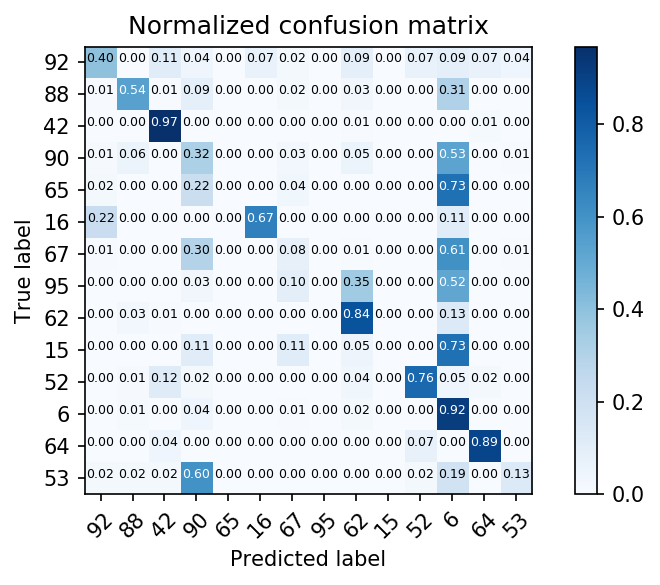

In [84]:




# Compute confusion matrix
cnf_matrix = confusion_matrix(alllabel_val, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=TM.target.unique(),
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(dpi=150)
plot_confusion_matrix(cnf_matrix, classes=TM.target.unique(), normalize=True,
                      title='Normalized confusion matrix')

# plt.savefig('/Users/Nathan/OneDrive/WPI/CLASS/Machine Learning/Project/randomforest_nathan.png',dpi=150)
plt.show()


In [69]:
allshrink.head()

,passband0_mjd_size,passband1_mjd_size,passband2_mjd_size,passband3_mjd_size,passband4_mjd_size,passband5_mjd_size,passband0_passband_min,passband1_passband_min,passband2_passband_min,passband3_passband_min,...,peakfreq_2_negative,peakfreq_3_negative,peakfreq_4_negative,peakfreq_5_negative,trend_0,trend_1,trend_2,trend_3,trend_4,trend_5
0,15,10,22,20,31,39,0,1,2,3,...,0,0,0,0,2.223179,-1.353602,-1.787676,2.821305,-3.498904,16.369928
1,10,15,19,20,35,38,0,1,2,3,...,0,0,0,0,476.923815,77.507326,65.425958,58.419683,23.462505,24.470505
2,9,13,24,18,32,40,0,1,2,3,...,0,0,0,0,-42.024112,-6.257982,-26.959207,304.911727,-1.637113,10.919051
3,72,52,40,51,51,51,0,1,2,3,...,0,0,0,0,-12.615985,20.136205,-225.356765,30.317882,-25.771492,-15.034760
4,13,12,19,25,32,33,0,1,2,3,...,0,0,0,0,-33.886852,-2.028649,-6.215823,4.003193,22.022912,-6.506414


In [70]:
model_dic={}

In [74]:
def run_regrssion_allshrink(target):
#     train_obj_list, val_obj_list=split_train_validation(TM,0.3,distribution,target)
#     allshrink_train=pd.merge(allshrink,train_obj_list,how='inner',on=['object_id'])
#     allshrink_val=pd.merge(allshrink,val_obj_list,how='inner',on=['object_id'])
#     alllabel_train=allshrink_train[['object_id','target']]
#     alllabel_val=allshrink_val[['object_id','target']]
#     X,Y=transfrom_to_logistic_form(allshrink_train.drop(['target'],axis=1),alllabel_train,target)
#     X_val,Y_val=transfrom_to_logistic_form(allshrink_val.drop(['target'],axis=1),alllabel_val,target)
#     alllabel_train=alllabel_train['target'].apply(str)
#     alllabel_val=alllabel_val['target'].apply(str)

    allshrink2=allshrink.copy()
    alllabel2=alllabel.copy()
#     allshrink2['final_target']=[1 if x==target else 0 for x in data['target']]
    alllabel2['final_target']=[1 if x==target else 0 for x in alllabel2['target']]
    alllabel2=alllabel2.drop(['target'],axis=1)
    alllabel2=alllabel2.rename(columns={"final_target":"target"})
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
    sss.get_n_splits(allshrink2, alllabel2)
    for train_index,test_index in sss.split(allshrink2,alllabel2):
        X, X_val = allshrink2.iloc[train_index], allshrink2.iloc[test_index]
        Y, Y_val = alllabel2.iloc[train_index], alllabel2.iloc[test_index]
    

    clf1 = RandomForestClassifier(max_depth=10,random_state=0).fit(X, Y)
    score1=clf1.score(X_val,Y_val)
    print('RandomForest for class ', target,': ',score1)
    clf2 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, Y)
    score2=clf2.score(X_val,Y_val)
    print('Logistic for class ', target,': ',score2)
    model_dic[target]={}
    if(score1>score2):
        model_dic[target]['model']=pickle.dumps(clf1)
        model_dic[target]['acc']=score1
        
        cnf_matrix = confusion_matrix(Y_val, clf1.predict(X_val))
        np.set_printoptions(precision=2)
        plt.figure(dpi=100)
        plot_confusion_matrix(cnf_matrix, classes=Y_val.target.unique(), normalize=True,
                      title='Class {}'.format(target))
        plt.show()
    else:
        model_dic[target]['model']=pickle.dumps(clf2)
        model_dic[target]['acc']=score2
        
        cnf_matrix = confusion_matrix(Y_val, clf2.predict(X_val))
        np.set_printoptions(precision=2)
        plt.figure(dpi=100)
        plot_confusion_matrix(cnf_matrix, classes=Y_val.target.unique(), normalize=True,
                      title='Class {}'.format(target))
        plt.show()

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  92 :  0.9936305732484076


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  92 :  0.9282377919320595
Normalized confusion matrix
[[9.99e-01 8.76e-04]
 [1.81e-01 8.19e-01]]


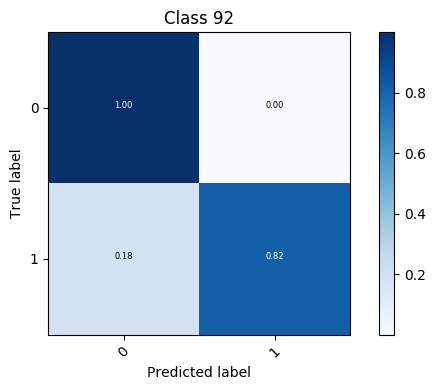

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  88 :  0.9817409766454352


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  88 :  0.9507430997876858
Normalized confusion matrix
[[1.   0.  ]
 [0.33 0.67]]


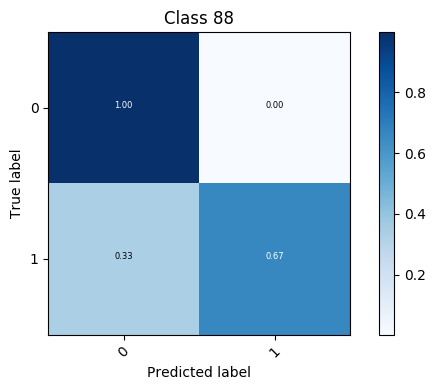

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  42 :  0.8564755838641189


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic for class  42 :  0.8467091295116773
Normalized confusion matrix
[[0.99 0.01]
 [0.88 0.12]]


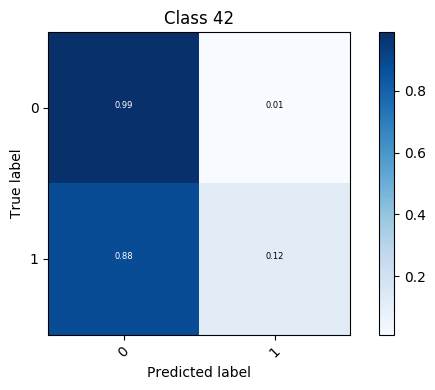

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  90 :  0.7983014861995754


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic for class  90 :  0.700212314225053
Normalized confusion matrix
[[0.86 0.14]
 [0.35 0.65]]


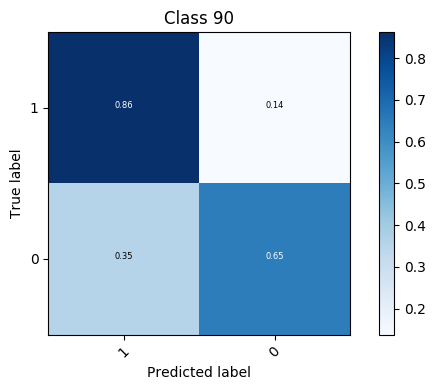

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  65 :  0.9524416135881104


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  65 :  0.873036093418259
Normalized confusion matrix
[[0.99 0.01]
 [0.34 0.66]]


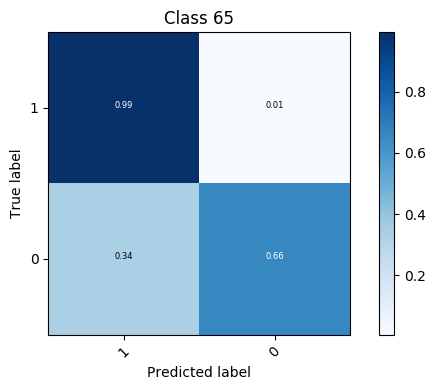

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  16 :  0.9881104033970276


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  16 :  0.8866242038216561
Normalized confusion matrix
[[1.   0.  ]
 [0.08 0.92]]


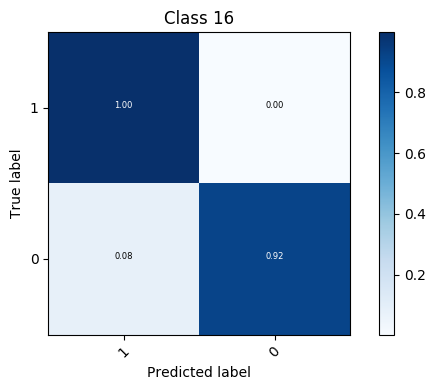

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  67 :  0.972823779193206


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  67 :  0.9736730360934183
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


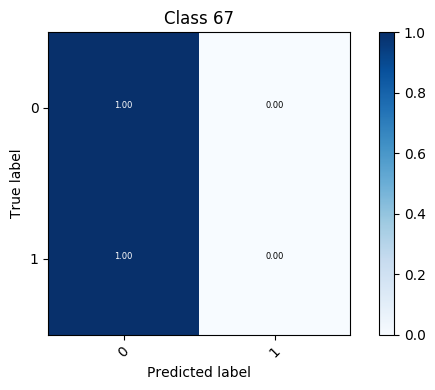

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  95 :  0.9787685774946921


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic for class  95 :  0.9749469214437367
Normalized confusion matrix
[[1.   0.  ]
 [0.94 0.06]]


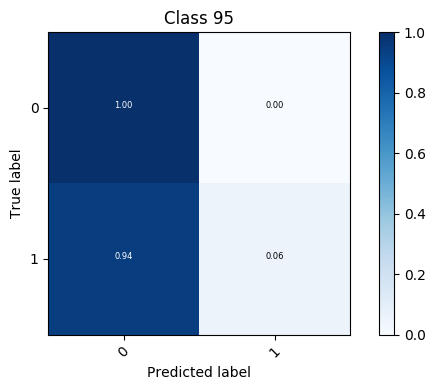

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  62 :  0.9380042462845011


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  62 :  0.9371549893842888
Normalized confusion matrix
[[9.99e-01 9.05e-04]
 [9.93e-01 6.90e-03]]


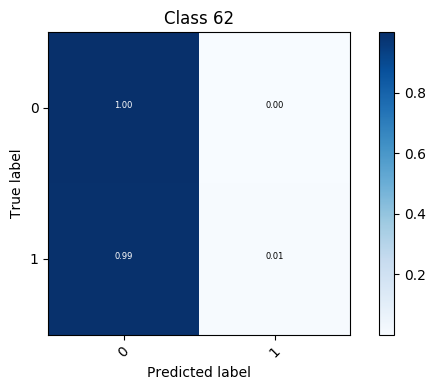

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  15 :  0.9554140127388535


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic for class  15 :  0.9312101910828026
Normalized confusion matrix
[[0.99 0.01]
 [0.58 0.42]]


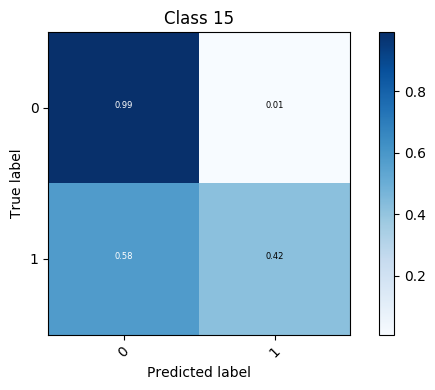

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  52 :  0.9766454352441614


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  52 :  0.975796178343949
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


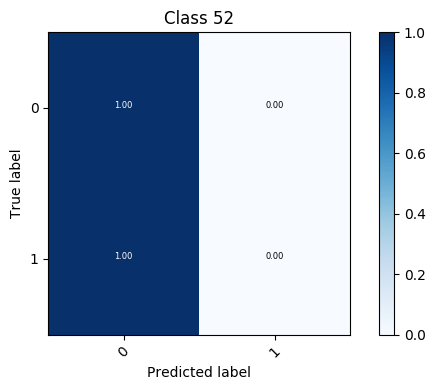

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  6 :  0.9830148619957537


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  6 :  0.9800424628450106
Normalized confusion matrix
[[1.   0.  ]
 [0.82 0.18]]


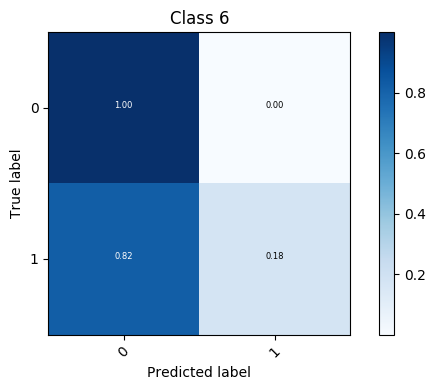

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  64 :  0.986411889596603


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  64 :  0.9855626326963907
Normalized confusion matrix
[[1.0e+00 4.3e-04]
 [1.0e+00 0.0e+00]]


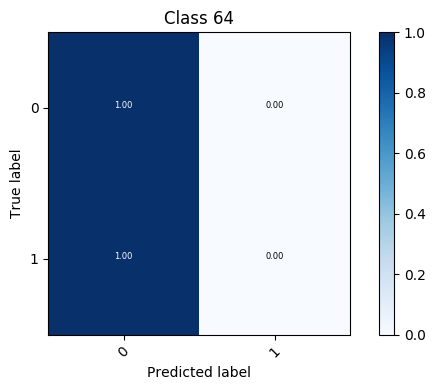

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest for class  53 :  0.9983014861995754


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic for class  53 :  0.9910828025477707
Normalized confusion matrix
[[1.   0.  ]
 [0.44 0.56]]


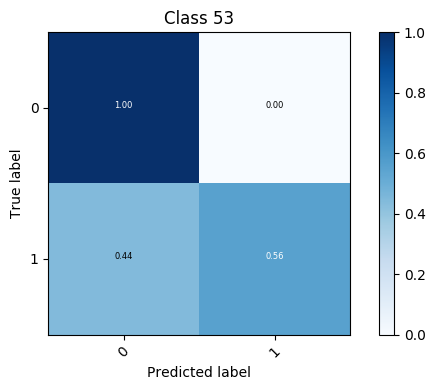

In [75]:
alltheclass=TM.target.unique()
for c in alltheclass:
    run_regrssion_allshrink(c)

In [94]:
binarymodel_list=[16,92,53,65,88,90,15,6,42,95,62,67,52,64]
# binary_shrink=allshrink.iloc[5233:7848].copy()
binary_shrink=allshrink_val.copy()
binary_shrink['predict']=0
predict_result=pd.DataFrame()
true_result=pd.DataFrame(alllabel_val)

In [ ]:
allshrink

In [95]:
for target in binarymodel_list:
    clf=pickle.loads(model_dic[target]['model'])
    X_val=binary_shrink[binary_shrink['predict']==0]
#     print(X_val[:,'object_id'])
    predict_sub_result=pd.DataFrame(X_val['object_id'])
    X_val=X_val.drop(['object_id','predict'],axis=1)
    pred=clf.predict(X_val)
    for i in range(len(pred)):
        if pred[i]==1:
            pred[i]=target
    predict_sub_result['predict']=pred
    predict_result=predict_result.append(predict_sub_result[predict_sub_result['predict']!=0],ignore_index=True)
    # update binary_shrink
    for index,row in predict_sub_result.iterrows():
        if row['predict']!=0:
            obj=row['object_id']
            binary_shrink.loc[binary_shrink['object_id']==obj,'predict']=target

In [96]:
true_result=TM[['object_id','target']]
true_result=pd.merge(true_result,binary_shrink,how='inner',on='object_id')


In [97]:
acc=0
for index, row in true_result.iterrows():
    if row['target']==row['predict']:
        acc+=1
print(acc/2543)

0.6110892646480535


Normalized confusion matrix
[[0.91 0.   0.   0.   0.   0.   0.   0.   0.03 0.   0.   0.06 0.   0.  ]
 [0.   0.92 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.08 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.03 0.   0.52 0.   0.   0.   0.   0.01 0.   0.   0.45 0.   0.  ]
 [0.   0.   0.   0.   0.39 0.   0.   0.   0.   0.   0.   0.61 0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.07 0.   0.   0.46 0.   0.   0.   0.   0.46 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.94 0.   0.   0.   0.06 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.07 0.   0.   0.   0.   0.93 0.   0.  ]
 [0.   0.01 0.03 0.   0.   0.   0.   0.   0.   0.   0.95 0.01 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.   0.98 0.  ]
 [0.   0.04 0.   0.21 0

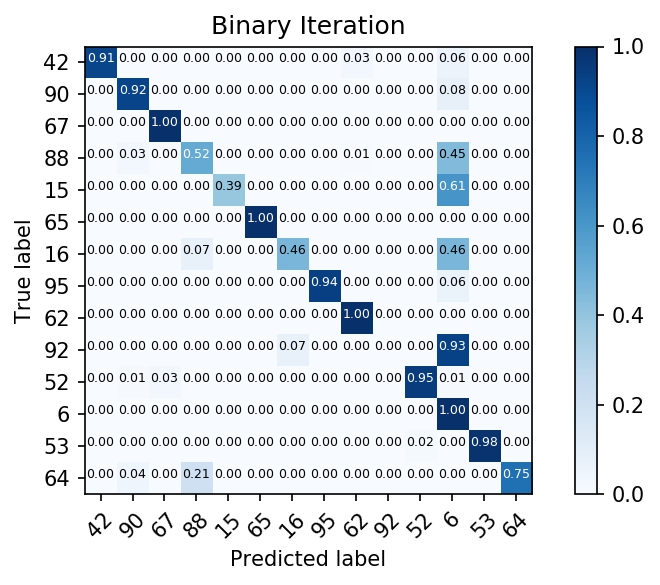

In [107]:
plt.figure(dpi=150)
cnf_matrix_binary = confusion_matrix(true_result[true_result['predict']!=0]['target'], true_result[true_result['predict']!=0]['predict'])
plot_confusion_matrix(cnf_matrix_binary, classes=true_result.target.unique(), normalize=True,
                      title='Binary Iteration')

In [59]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10,random_state=0).fit(X, Y)
clf.score(X_val,Y_val)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8653926628539546

In [64]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X, Y)
clf.score(X_val,Y_val)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9309527130701633